# Convolution layer and pooling

This notebook provides a concrete demonstration of how convolutional layers work. The goal is to give you a deeper understanding of this very useful operation.

See the [*convolutional arithmetic*](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) article by Vincent Dumoulin and Francesco Visin for detailed explanations of how convolutions can be configured, and how different configurations are used. (Image credit: Dumoulin & Visin)

*Note:* The code cells re-use variable name `x`, so they must be run in the order presented. This is not a best practice for notebooks but is used to keep variable names simple in this demo.

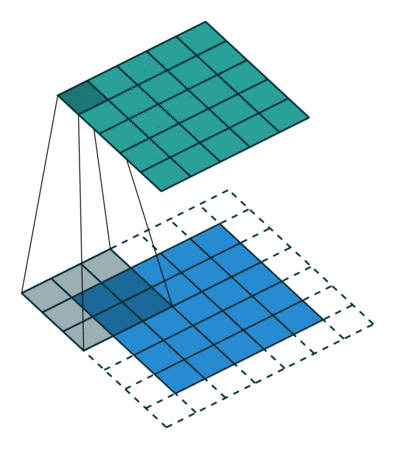

In [ ]:
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch

## Create synthetic image

In [ ]:
def make_synthetic():
    x = np.zeros((10, 12), dtype=np.float32)
    x[2:5,2:5] = -1
    x[4:8,4:10] = +1
    return x

x = make_synthetic()
x

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
      dtype=float32)

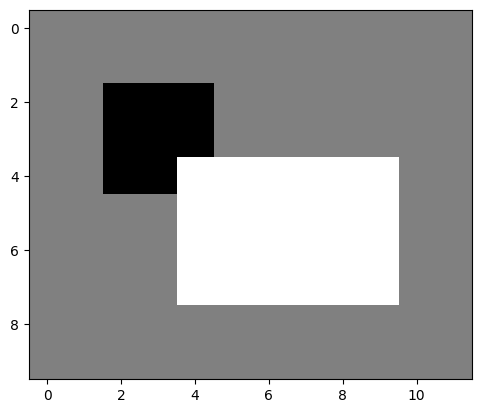

In [ ]:
plt.imshow(x, cmap='gray');

## Convolution implemented in Python

In [ ]:
def conv_py(x, w):
    """Convolution of a single 2D input x with a single filter w, both in (H,W) format."""
    xn, xm = x.shape
    wn, wm = w.shape
    an, am = (xn-wn+1, xm-wm+1)         # size of output feature map
    a = np.zeros((an, am), dtype=np.float32)
    for ai in range(an):                # loop over output row ai
        for aj in range(am):            # loop over output col aj
            for wi in range(wn):        # loop over filter row wi
                for wj in range(wm):    # loop over filter col wj
                    xi = ai + wi        # calculate input row xi
                    xj = aj + wj        # calculate input col xj
                    a[ai,aj] += w[wi,wj] * x[xi,xj]  # contribute x[xi,xj] to a[ai,aj]
    return a

Define a "vertical edge detector" pattern as an example

In [ ]:
w = np.array([[-1, +1],
              [-1, +1]], dtype=np.float32)

Convolve synthetic image with the "vertical-edge detector" filter

In [ ]:
a = conv_py(x, w)
a.shape

(9, 11)

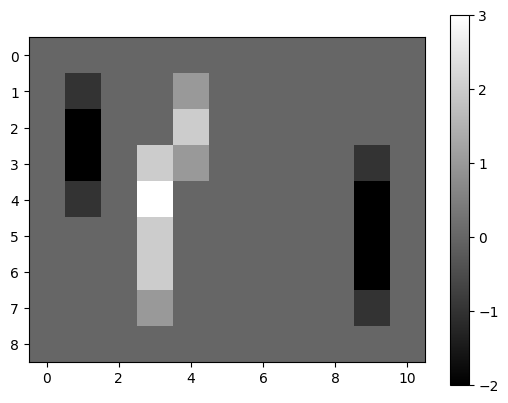

In [ ]:
plt.imshow(a, cmap='gray'); plt.colorbar();

## Convert image from (H,W) format to (N,C,H,W) format for PyTorch

* Matplotlib expects (height, width[, num_channels]) format tensors.
* PyTorch expects (batch_size, num_channels, height, width) format tensors.

In [ ]:
def hwc_to_nchw(x):
    """Convert x from (H,W[,C]) to (N,C,H,W) format where N=1."""
    if x.ndim < 3:
        x = x.unsqueeze(2)
    return x.permute(2, 0, 1).unsqueeze(0)

In [ ]:
print("before:", type(x), x.shape)
x = hwc_to_nchw(torch.from_numpy(x))
print("after: ", type(x), x.shape)

before: <class 'numpy.ndarray'> (10, 12)
after:  <class 'torch.Tensor'> torch.Size([1, 1, 10, 12])


## Convolution in PyTorch

In [ ]:
torch.manual_seed(0);  # Ensure PyTorch uses same random initial weights

conv = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=2, stride=1, padding=0)

PyTorch convolution weights organized as *weight[out_channel, in_channel, filter_row, filter_col]* and *bias[out_channel]*

In [ ]:
print("parameter weights:", type(conv.weight), conv.weight.shape)
print("parameter biases: ", type(conv.bias), conv.bias.shape)

parameter weights: <class 'torch.nn.parameter.Parameter'> torch.Size([2, 1, 2, 2])
parameter biases:  <class 'torch.nn.parameter.Parameter'> torch.Size([2])


In [ ]:
conv.weight

Parameter containing:
tensor([[[[-0.0037,  0.2682],
          [-0.4115, -0.3680]]],


        [[[-0.1926,  0.1341],
          [-0.0099,  0.3964]]]], requires_grad=True)

In [ ]:
conv.bias

Parameter containing:
tensor([-0.0444,  0.1323], requires_grad=True)

## Convolve with random weights

In [ ]:
a = conv(x)
print("activation map:", a.shape)      # (N,C,H,W) format

activation map: torch.Size([1, 2, 9, 11])


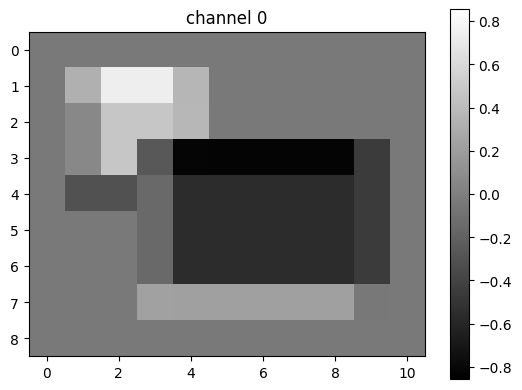

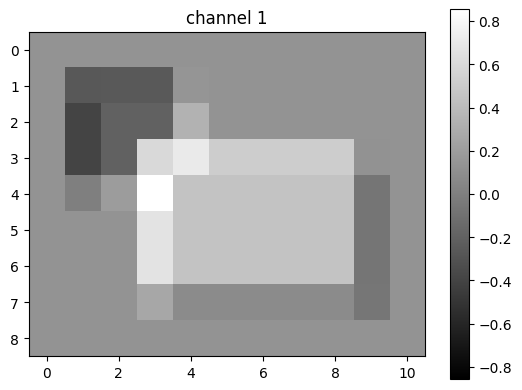

In [ ]:
def plot_channels(x, **kwargs):
    """Plot each channel in z as an image, where z is in (C,H,W) format."""
    vmax = max(-x.min(), x.max())   # Range of values
    for i, channel in enumerate(x):
        plt.figure(**kwargs);
        plt.imshow(channel.detach(), vmin=-vmax, vmax=vmax, cmap='gray');
        plt.colorbar();
        plt.title("channel %d" % i)

plot_channels(a[0])

## Convolve with hand-crafted parameters

Set filter 0 to be vertical edge detector, filter 1 to be horizontal edge detector.

In [ ]:
conv.weight.data[0,:] = torch.tensor([[[-1, +1],
                                       [-1, +1]]])

conv.weight.data[1,:] = torch.tensor([[[-1, -1],
                                       [+1, +1]]])

conv.bias.data[:] = 0

In [ ]:
conv.weight

Parameter containing:
tensor([[[[-1.,  1.],
          [-1.,  1.]]],


        [[[-1., -1.],
          [ 1.,  1.]]]], requires_grad=True)

In [ ]:
conv.bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

Show the resulting activation maps for our synthetic image

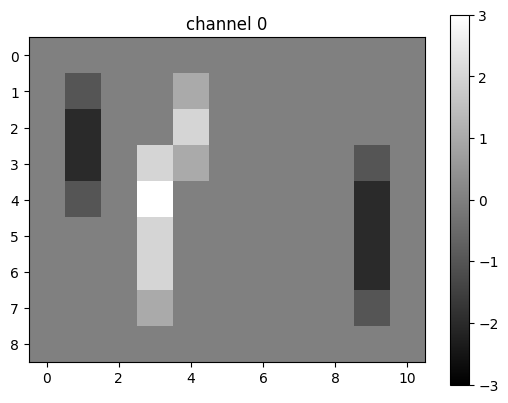

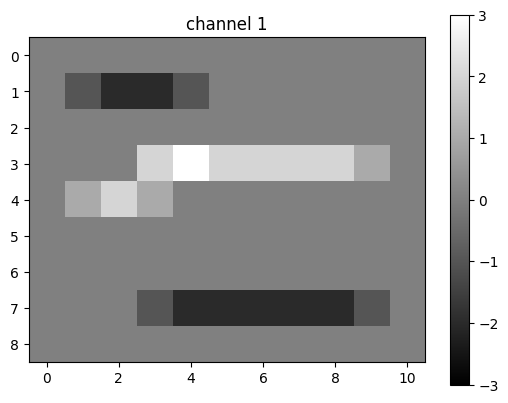

In [ ]:
a = conv(x)
plot_channels(a[0])

## Plot feature maps

By applying a non-linearity such as ReLU, we turn activation maps into feature maps.

In [ ]:
func = torch.nn.ReLU()

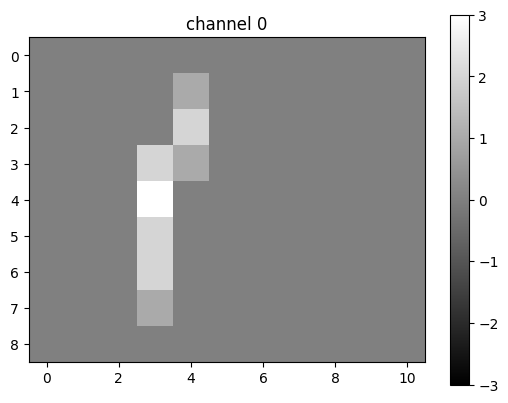

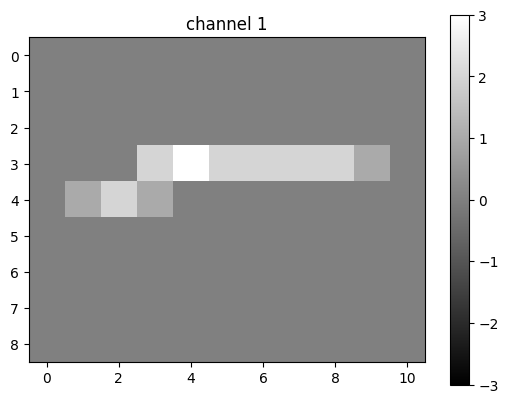

In [ ]:
z = func(a)
plot_channels(z[0])

## Convolve on real image

Let's download a real image:

In [ ]:
!gdown 11_0HrPXch92SDQIdlyXP6nGVDp6-U_ys

Downloading...
From: https://drive.google.com/uc?id=11_0HrPXch92SDQIdlyXP6nGVDp6-U_ys
To: /content/convolution_layer_demo.png
100% 27.0k/27.0k [00:00<00:00, 58.9MB/s]


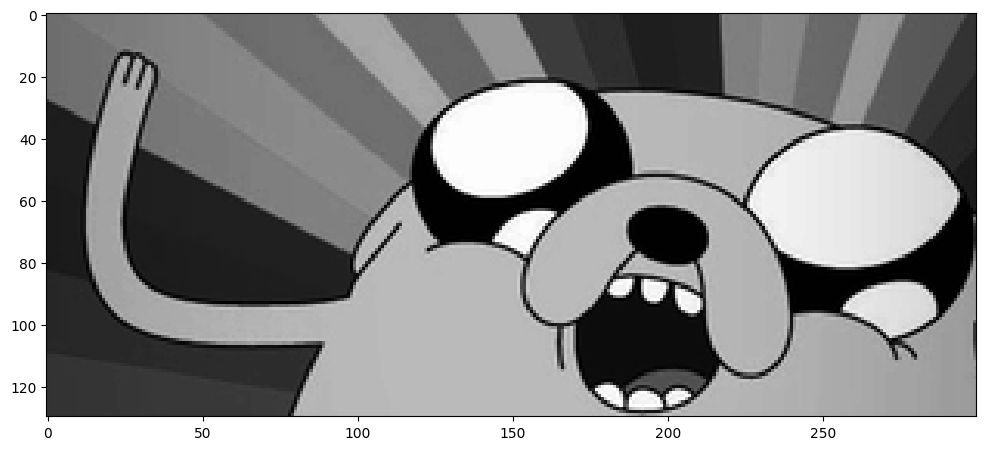

In [ ]:
def load_example():
    x = plt.imread('convolution_layer_demo.png')
    return torch.from_numpy(x)

x = load_example()
plt.figure(figsize=(12,24))
plt.imshow(x, cmap='gray');

In [ ]:
x = hwc_to_nchw(x)
x.shape

torch.Size([1, 1, 130, 300])

Compute activation map using our two 2x2 filters from earlier

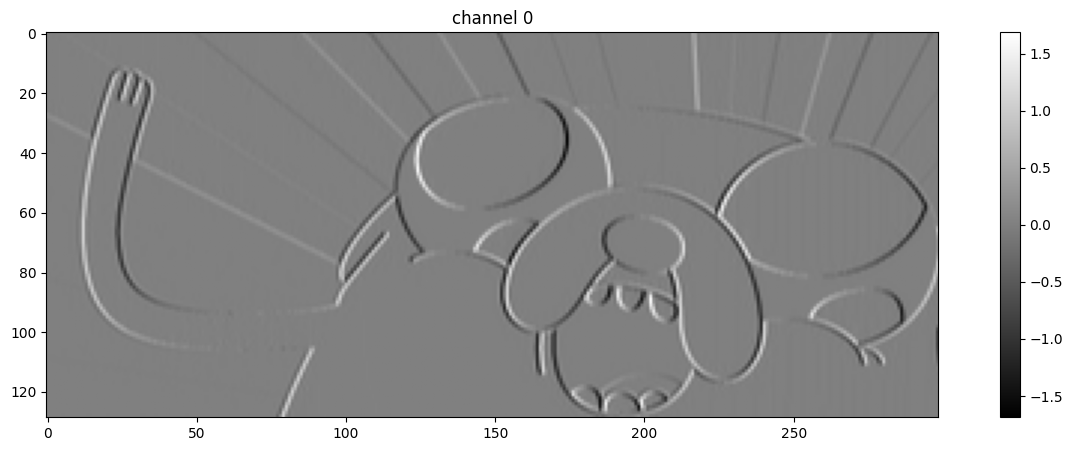

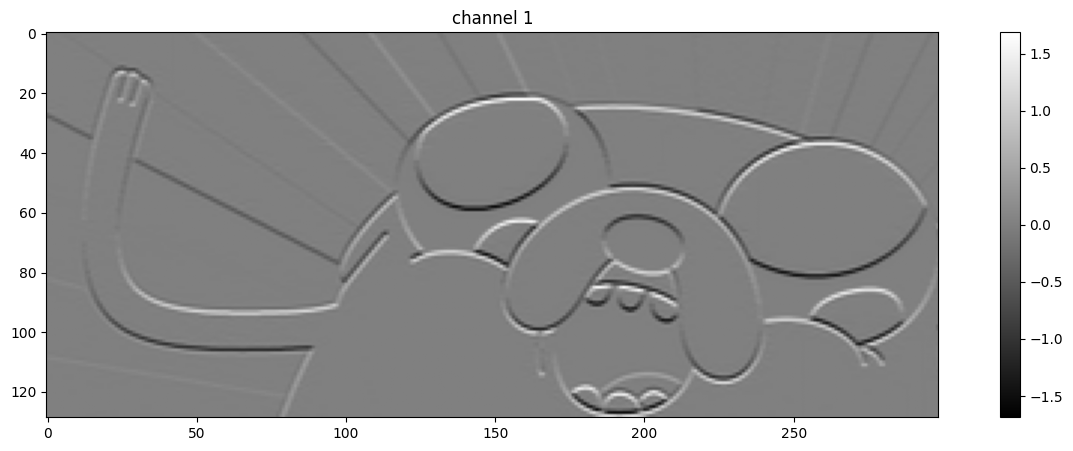

In [ ]:
a = conv(x)
plot_channels(a[0], figsize=(16, 5))

Compute feature maps from the activation maps

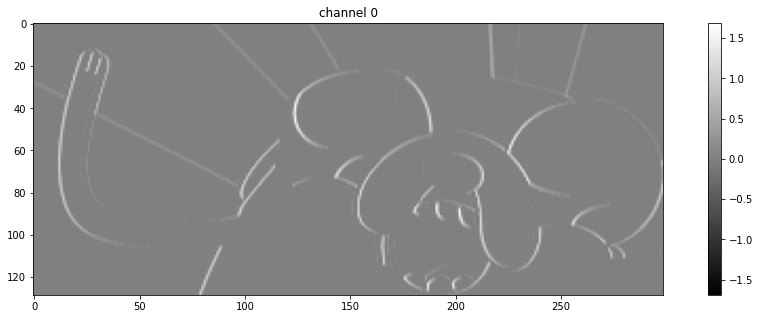

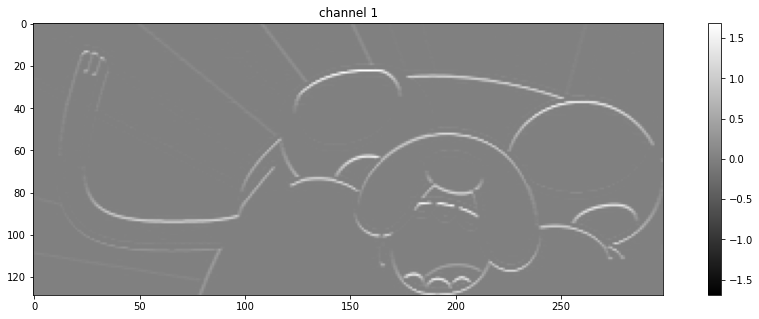

In [ ]:
z = func(a)
plot_channels(z[0], figsize=(16, 5))

## Compare running times (PyTorch vs pure Python)

In [ ]:
%time a = conv_py(x[0,0], w)   # Python (1 filter only)
%time a = conv(x)              # PyTorch (2 filters)

CPU times: user 3.4 s, sys: 12.4 ms, total: 3.41 s
Wall time: 3.43 s
CPU times: user 2.76 ms, sys: 0 ns, total: 2.76 ms
Wall time: 1.81 ms


## Pooling in Python

Max-pooling is common layer in convolutional architectures. It reduces the spatial resolution of a feature map, but tries to preserve the most highly active value (the maximal values) within each "pooling region".

In [ ]:
def maxpool_py(x, s):
    """2D max pooling of x over a region size s with stride s."""
    xn, xm = x.shape
    an, am = (xn//s, xm//s)          # size of output feature map
    a = np.full((an, am), -np.inf, dtype=np.float32)
    for ai in range(an):             # loop over output row ai
        for aj in range(am):         # loop over output col aj
            for ri in range(s):      # loop over region row ri
                for rj in range(s):  # loop over region col rj
                    xi = ai*s + ri   # calculate input row xi
                    xj = aj*s + rj   # calculate input col xj
                    a[ai,aj] = max(a[ai,aj], x[xi,xj])  # contribute x[xi,xj] to a[ai,aj]
    return a

First, show the convolution from earlier as a reference, with non-overlapping 2x2 pooling regions plotted via a grid.

In [ ]:
x = make_synthetic()
a = conv_py(x, w)

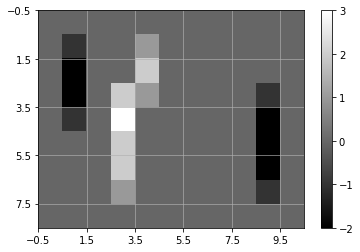

In [ ]:
plt.imshow(a, vmin=-2, vmax=3,cmap='gray'); plt.colorbar();
plt.xticks(np.arange(0, a.shape[1], 2)-.5)
plt.yticks(np.arange(0, a.shape[0], 2)-.5)
plt.grid(True, alpha=0.8)

Show the result of max-pooling non-overlapping regions with a stride of 2

In [ ]:
z = maxpool_py(a, 2)
z

array([[0., 0., 1., 0., 0.],
       [0., 2., 2., 0., 0.],
       [0., 3., 0., 0., 0.],
       [0., 2., 0., 0., 0.]], dtype=float32)

Plot the new (pooled) feature map as an image.

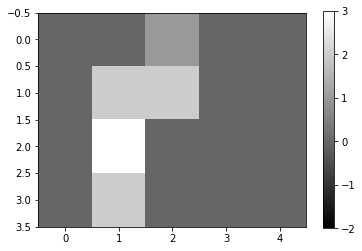

In [ ]:
plt.imshow(z, vmin=-2, vmax=3, cmap='gray'); plt.colorbar();

## Pooling in PyTorch

Show how to implement the same pooling operation, but with PyTorch.

In [ ]:
pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

Pool the activation map directly, for simplicity.

In [ ]:
x = hwc_to_nchw(torch.from_numpy(x))   # convert to PyTorch format
a = conv(x)                            # compute activation maps
z = func(a)                            # compute feature maps
z = pool(z)                            # compute pooled feature maps
z                                      # first should match Python version

tensor([[[[0., 0., 1., 0., 0.],
          [0., 2., 2., 0., 0.],
          [0., 3., 0., 0., 0.],
          [0., 2., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 2., 3., 2., 2.],
          [1., 2., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)